# **가위바위보 분류기 만들기**
## ● 개요
이미지를 직접 수집하여 가위바위보 분류기를 만든다
## ● 목차
**1. 데이터 전처리**  
1.1. 데이터 불러오기 & 리사이즈  
1.2. 이미지 라벨링하기  
1.3. 훈련 / 테스트 세트 분리  
**2. 학습시키기**  
**3. 테스트하기**  

## ● 본문

In [134]:
# 라이브러리 버전 확인
import tensorflow as tf
import numpy as np

print(tf.__version__)
print(np.__version__)

2.6.0
1.22.2


In [135]:
# 데이터 불러오기 + Resize 하기
from PIL import Image
import glob
import os

print("PIL 라이브러리 import 완료!")

PIL 라이브러리 import 완료!


In [136]:
# 이미지 리사이즈 : 가위
def resize_images(img_path):
	images=glob.glob(img_path + "/*.jpg")  
    
	print(len(images), " images to be resized.")

    # 파일마다 모두 28x28 사이즈로 바꾸어 저장합니다.
	target_size=(28,28)
	for img in images:
		old_img=Image.open(img)
		new_img=old_img.resize(target_size,Image.ANTIALIAS)
		new_img.save(img, "JPEG")
    
	print(len(images), " images resized.")
	
    
# 가위 이미지가 저장된 디렉토리 아래의 모든 jpg 파일을 읽어들여서
image_dir_path = os.getenv("HOME") + "/aiffel/rock_scissor_paper/scissor"
resize_images(image_dir_path)
print("가위 이미지 resize 완료!")

# 바위
image_dir_path = os.getenv("HOME") + "/aiffel/rock_scissor_paper/rock"
resize_images(image_dir_path)
print("바위 이미지 resize 완료!")

# 보
image_dir_path = os.getenv("HOME") + "/aiffel/rock_scissor_paper/paper"
resize_images(image_dir_path)
print("보 이미지 resize 완료!")

300  images to be resized.
300  images resized.
가위 이미지 resize 완료!
300  images to be resized.
300  images resized.
바위 이미지 resize 완료!
300  images to be resized.
300  images resized.
보 이미지 resize 완료!


In [137]:
# load_data() 함수 : 이미지 데이터를 읽을 수 있다
# 입력으로 이미지가 있는 폴더 위치를 받음
# 3개의 클래스 즉, 가위: 0, 바위: 1, 보: 2 로 라벨링됨

import numpy as np

def load_data(img_path, number_of_data=900):  # 가위바위보 이미지 개수 총합에 주의하세요.
    # 가위 : 0, 바위 : 1, 보 : 2
    img_size=28
    color=3
    #이미지 데이터와 라벨(가위 : 0, 바위 : 1, 보 : 2) 데이터를 담을 행렬(matrix) 영역을 생성합니다.
    imgs=np.zeros(number_of_data*img_size*img_size*color,dtype=np.int32).reshape(number_of_data,img_size,img_size,color)
    labels=np.zeros(number_of_data,dtype=np.int32)

    idx=0
    for file in glob.iglob(img_path+'/scissor/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
        labels[idx]=0   # 가위 : 0
        idx=idx+1

    for file in glob.iglob(img_path+'/rock/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
        labels[idx]=1   # 바위 : 1
        idx=idx+1  
    
    for file in glob.iglob(img_path+'/paper/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
        labels[idx]=2   # 보 : 2
        idx=idx+1
        
    print("데이터(X)의 이미지 개수는", idx,"입니다.")
    return imgs, labels

image_dir_path = os.getenv("HOME") + "/aiffel/rock_scissor_paper"
(X, y)=load_data(image_dir_path)
X_norm = X/255.0   # 입력은 0~1 사이의 값으로 정규화

# 정규화되었는지 확인한다
print('최소값: ', np.min(X_norm), '최대값: ', np.max(np.max(X_norm)) )

print("X shape: {}".format(X_norm.shape))
print(" shape: {}".format(y.shape))

데이터(X)의 이미지 개수는 900 입니다.
최소값:  0.0 최대값:  1.0
X shape: (900, 28, 28, 3)
 shape: (900,)


In [138]:
# 데이터 테스트세트 분리하기
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_norm, y, test_size=0.25, shuffle = True, random_state = 19)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((675, 28, 28, 3), (225, 28, 28, 3), (675,), (225,))

라벨:  1


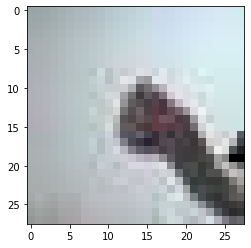

In [139]:
# 첫번째 데이터를 로드해본다(이미지, 라벨)
import matplotlib.pyplot as plt

plt.imshow(X_train[0])
print('라벨: ', y_train[0])

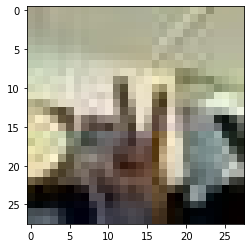

21 번째 이미지의 숫자는 바로  0 입니다.


In [140]:
# 임의의 데이터에대해 이미지, 라벨 확인
index=20
plt.imshow(x_train[index],cmap=plt.cm.binary)
plt.show()
print( (index+1), '번째 이미지의 숫자는 바로 ',  y_train[index], '입니다.')

### 딥러닝 네트워크 설계하기

In [141]:
import tensorflow as tf
from tensorflow import keras
import numpy as np

# 데이터셋 로드 및 전처리
# (이미지 데이터셋과 레이블 데이터셋을 각각 X_train, y_train, X_test, y_test로 로드하고 전처리하는 부분)

# 모델 정의
model = keras.models.Sequential()
model.add(keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(28,28,3)))
model.add(keras.layers.MaxPooling2D(2,2))
model.add(keras.layers.Conv2D(32, (3,3), activation='relu'))
model.add(keras.layers.MaxPooling2D((2,2)))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(32, activation='relu'))
model.add(keras.layers.Dense(3, activation='softmax')) # 클래스 개수가 3이므로 출력 뉴런 수를 3으로 설정


### 딥러닝 네트워크 학습시키기

In [142]:
# model을 학습시키는 코드를 직접 작성해 보세요.
# Hint! model.compile()과 model.fit()을 사용해 봅시다.
# [[YOUR CODE]]

# 모델 컴파일
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# 모델 학습
history = model.fit(X_train, y_train, epochs=30)


Epoch 1/30
22/22 [==============================] - 1s 20ms/step - loss: 1.0664 - accuracy: 0.4667
Epoch 2/30
22/22 [==============================] - 0s 21ms/step - loss: 0.9584 - accuracy: 0.6148
Epoch 3/30
22/22 [==============================] - 0s 20ms/step - loss: 0.7879 - accuracy: 0.7437
Epoch 4/30
22/22 [==============================] - 0s 19ms/step - loss: 0.5696 - accuracy: 0.8044
Epoch 5/30
22/22 [==============================] - 0s 22ms/step - loss: 0.4304 - accuracy: 0.8622
Epoch 6/30
22/22 [==============================] - 0s 20ms/step - loss: 0.3160 - accuracy: 0.8948
Epoch 7/30
22/22 [==============================] - 0s 22ms/step - loss: 0.2683 - accuracy: 0.9081
Epoch 8/30
22/22 [==============================] - 0s 19ms/step - loss: 0.2128 - accuracy: 0.9422
Epoch 9/30
22/22 [==============================] - 0s 20ms/step - loss: 0.1947 - accuracy: 0.9363
Epoch 10/30
22/22 [==============================] - 0s 20ms/step - loss: 0.1589 - accuracy: 0.9600
Epoch 11/

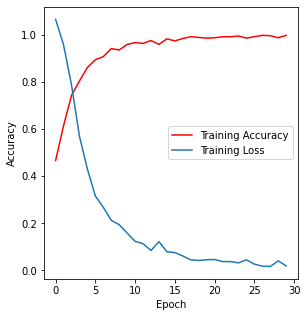

In [147]:
# 학습 과정에서의 손실(loss)과 정확도(accuracy)를 그래프로 그리기
plt.figure(figsize=(10, 5))

# 정확도 & 손실 그래프
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy', c='r')
plt.plot(history.history['loss'], label='Training Loss')

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Epoch이 23회정도일 때 정확도가 최대값이된다

### 얼마나 잘 만들었는지 확인하기(테스트)

In [145]:
# model을 학습시키는 코드를 직접 작성해 보세요.
# Hint! model.evaluate()을 사용해 봅시다.
# [[YOUR CODE]]

# 모델 평가
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print("Test loss:", test_loss)
print("Test accuracy:", test_accuracy)

# Test accuracy: 0.9777777791023254

8/8 [==============================] - 0s 10ms/step - loss: 0.0318 - accuracy: 0.9956
Test loss: 0.03181679546833038
Test accuracy: 0.995555579662323


## ● 회고
직접 데이터를 만들어서 분류기를 만드는 과정이 흥미로웠다
이번에 이용한 keras는 이번 노드를 처음 접했을 때도 공부한 것이다.  
당시에는 adam이 뭔지 softmax가 뭔지 전혀 모르고 무작정 따라만했는데, 책을 한 번 완독하고 다시 보니 이제 의미를 알게 되어 감회가 남달랐다.  
사실 이미지 리사이즈 부분과 라벨링하는 코드는 처음 접해 해독하는 것도 버거웠다. 부족한 부분은 주말동안 다시 한줄한줄 의미를 되새기며 복습해야겠다!

## ● reference
- 데이터 분리하기 : https://mgyo.tistory.com/75
- 터미널 사용방법 : https://heytech.tistory.com/35
- glob.glob() 사용법 : https://m.blog.naver.com/siniphia/221397012627
